In [1]:

import time
import matplotlib 
import matplotlib.pyplot as plt 
import sklearn
from sklearn import cross_validation,metrics,datasets, preprocessing, linear_model,svm,neighbors,grid_search,dummy
from sklearn import naive_bayes,tree,ensemble,neural_network
import pandas as pd 
import seaborn as sns 
import xgboost as xgb 
import numpy as np
import scipy.io

%matplotlib inline 

#set seed for all randomized algos 
seed = 42 
print("preambles loaded.")

preambles loaded.


In [2]:
#the usual utils 


    


def load_dataset(path="/home/sanders/data/viral/data.csv"):
    import pandas as pd
    data = pd.read_csv(path)
    print("data loaded.")
    return data

def seperator(message=""):
    print()
    print("-"*80)
    print(message)
    print("-"*80)
    print()
    
def make_kaggle_submit_csv(predictions): 
    return predictions

def logging(message="\n"):
    current_time = time.ctime()
    path = "/home/sanders/notebooks/microarray/logging.txt"
    with open(path,"a") as f: 
        f.write("-"*80 + "\n")
        f.write(current_time+"\n")
        f.write(message)
        f.write("\n")
        
#plotting utils 
def plot_roc_curve(false_positive_rates,true_positive_rates,auc_score):
    plt.plot([0,1],[0,1],"k--")
    plt.plot(false_positive_rates,true_positive_rates,"r-",label = "ROC curve (auc: %0.3f)"%(auc_score))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("false positive rate (1 - specificity)")
    plt.ylabel("true polsitive rate(sensitivity)")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()
    
def plot_validation_curve(train_scores,validation_scores,ticks,semilogx = False):
    if semilogx: 
        plt.semilogx(ticks,train_scores.mean(axis=1),"b--",label = "training")
        plt.fill_between(ticks,train_scores.mean(axis=1)-train_scores.std(axis=1),
                        train_scores.mean(axis=1)+train_scores.std(axis=1),alpha=0.2,color="b")
        plt.semilogx(ticks,validation_scores.mean(axis=1),"r--",label="validation")
        plt.fill_between(ticks,validation_scores.mean(axis=1)-validation_scores.std(axis=1),
                        validation_scores.mean(axis=1)+validation_scores.std(axis=1),alpha=0.2,color="r")
    else: 
        plt.plot(ticks,train_scores,"b--",label = "training")
#         plt.fill_between(ticks,train_scores.mean(axis=1-train_scores.std(axis=1),
#                         train_scores.mean(axis=1)+train_scores.std(axis=1),alpha=0.2,color="b")
        plt.plot(ticks,validation_scores,"r--",label="validation")
#         plt.fill_between(ticks,validation_scores.mean(axis=1)-validation_scores.std(axis=1),
#                         validation_scores.mean(axis=1)+validation_scores.std(axis=1),alpha=0.2,color="r")
        
    plt.legend(loc="best")
    plt.show()

def get_numpy_arrays(data_raw):
    x = mat["X"]
    y = mat["Y"] #encoded as 1,2 
    y = y.reshape((y.shape[0],))
    #change encoding of 1,2 to 0,1 
    y[y==1] = 0 
    y[y==2] = 1
    # print(y)
    return(x,y)

def get_pandas_df(numpy_x,numpy_y,verbose=False):
    feature_names = [str(i) for i in range(numpy_x.shape[1])]
    #convert to pandas df 
    data_x = pd.DataFrame(numpy_x,columns=feature_names)
    data_y = pd.Series(numpy_y,name="y")
    if verbose:
        print("convertd to pandas df!! \n")
        seperator("data_x:")
        print(data_x.info())
        seperator("top 5 rows of data_x:")
        print(data_x.head(5))
        seperator("data_y:")
        print(data_y.value_counts())
        seperator("percentage of classes:")
        print(data_y.value_counts(normalize=True))
        
    return(data_x,data_y)

def combine_train_x_y_df(data_x,data_y):
    data = pd.concat([data_x,data_y],axis=1)
    return data

def visualize_pair_wise(data,feautures=None,cols_index_range = None,target="SHEDDING_SC1"):
    
    #see all pairwise relationship between features 
    if cols_index_range:
        f = data.columns[cols_index_range]
    else:
        f = feautures
    assert len(f) <= 10, "common man, too many features to fit in a plot!"
    
    g = sns.PairGrid(data,vars=f,hue=target)
    g.map_diag(sns.kdeplot)
    g.map_upper(sns.regplot)
    g.map_lower(sns.residplot)
    plt.legend()
    plt.show()




def visualize_distro(data,features=None,cols_index_range = None,target="SHEDDING_SC1"): 
    #sumary stats
    if cols_index_range: 
        tiny_x= data.iloc[:,cols_index_range]
    else:
        tiny_x= data.loc[:,features]
    for f in tiny_x: 
        seperator("featuer:%s"%f)
        #vanilla dist plot 
        sns.distplot(tiny_x[f])
        plt.show()
        #I want a fucking distplot wiht the two classes 
        g = sns.FacetGrid(data=data,hue=target)
        g.map(sns.distplot,f)
        plt.legend()
        plt.show()
        print(tiny_x[f].describe())

def visualize_scatter(data,feature1=None,feature2=None,feature_idx1=None,feature_idx2=None,target ="SHEDDING_SC1" ):
    if feature_idx1 and feature_idx2:
        f1 = data.columns[feature_idx1]
        f2 = data.columns[feature_idx2]
    else:
        f1 = feature1
        f2 = feature2
    seperator("feature:%s Vs. feature:%s"%(f1,f2))
    sns.lmplot(data=data,x=f1,y=f2,order=1,hue=target,markers=["o","x"])
    plt.show()
    g = sns.FacetGrid(data=data,hue=target)
    g.map(sns.residplot,f1,f2)

def visaulize_muliple_curves():
    pass 


######################33
#from koby uncleaned 

def make_kaggle_submit(prediction,file_name):
    idx = pd.Series(data["shot_id"][data["y"].isnull()].values.astype(dtype =int))
    predict = pd.Series(prediction)
    submit = pd.concat([idx,predict],axis=1,ignore_index=True,join="inner")
    submit.columns = ["shot_id","shot_made_flag"]
    submit.to_csv(base_path+file_name,index=False)
    return submit
    
def score_prediction(prediction,label):
    from sklearn import metrics 
    log_loss = metrics.log_loss(label,prediction,normalize=True)
    auc_score = metrics.roc_auc_score(label,prediction)
    accuracy_score = metrics.accuracy_score(label,prediction)
    print("log loss:%5.10f, auc:%5.f, accuracy:%.f"%(log_loss,auc_score,accuracy_score))
    
    
#begin with categorical features
def visualize_categoricals(train,cols_index_range = range(10),target = "SHEDDING_SC1"):

    for f in train.columns[cols_index_range]:
        if train[f].dtype == "object":
            seperator(message=f)
            print(train[f].value_counts())
            print(train[f].value_counts(normalize = True,sort=True,ascending=False))
            sns.countplot(data=train,x=f,hue=target)
            plt.show()
            print(train[[f,target]].groupby(f).mean())

# # the numerical features 
# for f in train:
#     if train[f].dtype != "object":#numerical 
#         seperator(message=f)
#         sns.distplot(a=train[f],hist=True,kde=True,rug=False)
#         plt.show()
#         sns.boxplot(x="y",y=f,data=train)
#         plt.show()
#         print(train[f].describe())

# load datasets 

In [14]:
data = load_dataset()

/home/sanders/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


data loaded.


In [67]:
da

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Columns: 22293 entries, Unnamed: 0 to LOGSYMPTSCORE_SC3
dtypes: float64(22288), int64(5)
memory usage: 16.2 MB


# EDA / Feature engineering

In [68]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Columns: 22293 entries, Unnamed: 0 to LOGSYMPTSCORE_SC3
dtypes: float64(22288), int64(5)
memory usage: 16.2 MB


Index(['Unnamed: 0', 'AGE', 'EARLYTX', '1007_s_at', '1053_at', '117_at',
       '121_at', '1255_g_at', '1294_at', '1316_at',
       ...
       'STUDYID_DEE4X H1N1', 'STUDYID_DEE5 H3N2', 'STUDYID_Rhinovirus Duke',
       'STUDYID_Rhinovirus UVA', 'GENDER_Female', 'GENDER_Male', 'Unnamed: 0',
       'SHEDDING_SC1', 'SYMPTOMATIC_SC2', 'LOGSYMPTSCORE_SC3'],
      dtype='object', length=22293)


--------------------------------------------------------------------------------
STUDYID
--------------------------------------------------------------------------------

DEE3 H1N1          474
DEE1 RSV           417
DEE2 H3N2          351
Rhinovirus Duke    328
DEE5 H3N2          297
Rhinovirus UVA     255
DEE4X H1N1         215
Name: STUDYID, dtype: int64
DEE3 H1N1          0.202824
DEE1 RSV           0.178434
DEE2 H3N2          0.150193
Rhinovirus Duke    0.140351
DEE5 H3N2          0.127086
Rhinovirus UVA     0.109114
DEE4X H1N1         0.091998
Name: STUDYID, dtype: float64


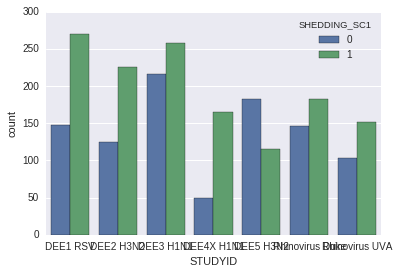

                 SHEDDING_SC1
STUDYID                      
DEE1 RSV             0.647482
DEE2 H3N2            0.643875
DEE3 H1N1            0.544304
DEE4X H1N1           0.767442
DEE5 H3N2            0.387205
Rhinovirus Duke      0.554878
Rhinovirus UVA       0.596078

--------------------------------------------------------------------------------
SUBJECTID
--------------------------------------------------------------------------------

RSV001    21
RSV013    21
flu017    21
RSV005    21
RSV019    21
RSV018    21
flu005    21
5013      21
5007      21
flu002    21
5021      21
RSV002    21
5017      21
5016      21
flu015    21
RSV008    21
RSV004    21
5009      21
5008      21
5002      21
5001      21
RSV020    21
RSV011    21
RSV003    21
flu014    21
RSV015    21
flu008    21
5011      21
RSV009    21
5015      21
          ..
5002       2
2          2
5005       2
5021       2
3          2
4          2
5001       2
5013       2
5007       2
5009       2
5015       2
9         

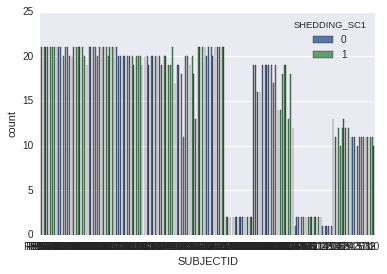

           SHEDDING_SC1
SUBJECTID              
1                     0
2                     0
3                     1
4                     1
5                     1
6                     1
7                     1
8                     0
9                     1
10                    0
11                    1
12                    1
13                    0
14                    0
15                    1
16                    1
17                    1
18                    0
19                    0
20                    1
3001                  1
3002                  0
3003                  1
3004                  0
3005                  0
3006                  1
3007                  0
3008                  1
3009                  1
3010                  1
...                 ...
RSV008                0
RSV009                0
RSV010                0
RSV011                1
RSV012                1
RSV013                1
RSV014                1
RSV015                1
RSV016          

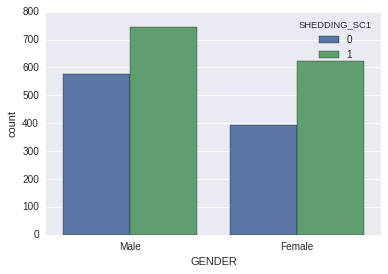

        SHEDDING_SC1
GENDER              
Female      0.613793
Male        0.563540


In [16]:
visualize_categoricals(train=data,cols_index_range=range(10))


--------------------------------------------------------------------------------
featuer:200068_s_at
--------------------------------------------------------------------------------



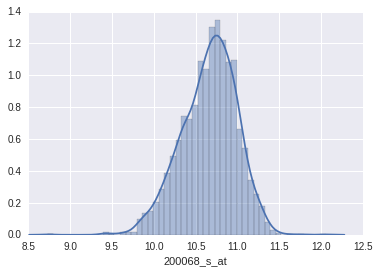

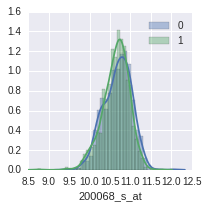

count    2337.000000
mean       10.660620
std         0.330430
min         8.731757
25%        10.448422
50%        10.693311
75%        10.890125
max        12.056848
Name: 200068_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200069_at
--------------------------------------------------------------------------------



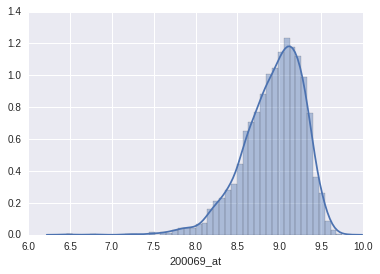

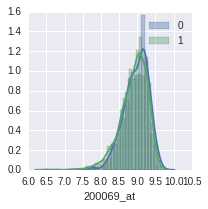

count    2337.000000
mean        8.931177
std         0.360882
min         6.458900
25%         8.720015
50%         8.985636
75%         9.194857
max         9.752835
Name: 200069_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200070_at
--------------------------------------------------------------------------------



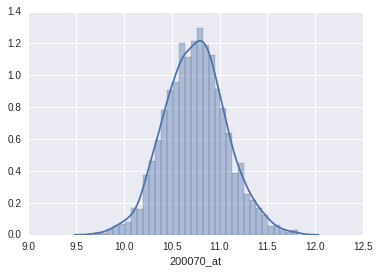

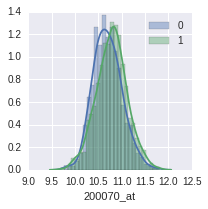

count    2337.000000
mean       10.748884
std         0.324537
min         9.696609
25%        10.529658
50%        10.749962
75%        10.954317
max        11.823358
Name: 200070_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200071_at
--------------------------------------------------------------------------------



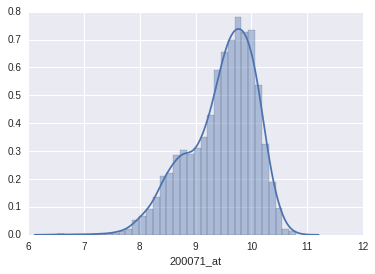

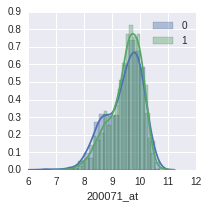

count    2337.000000
mean        9.469671
std         0.600955
min         6.521037
25%         9.093770
50%         9.582438
75%         9.919915
max        10.799018
Name: 200071_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200072_s_at
--------------------------------------------------------------------------------



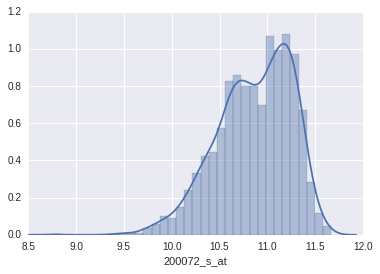

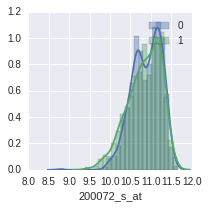

count    2337.000000
mean       10.862872
std         0.388187
min         8.764457
25%        10.605928
50%        10.907911
75%        11.174168
max        11.668240
Name: 200072_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200073_s_at
--------------------------------------------------------------------------------



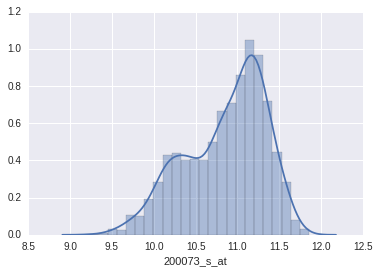

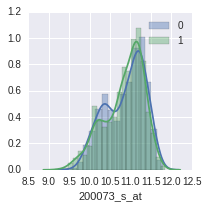

count    2337.000000
mean       10.855363
std         0.479724
min         9.231388
25%        10.490866
50%        10.958114
75%        11.220233
max        11.854128
Name: 200073_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200074_s_at
--------------------------------------------------------------------------------



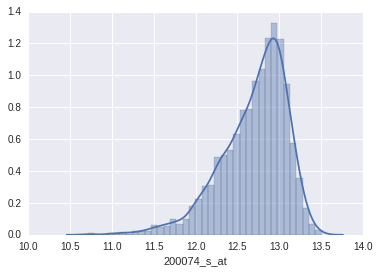

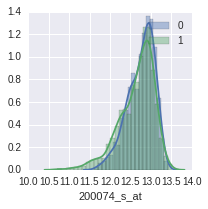

count    2337.000000
mean       12.696301
std         0.394972
min        10.713275
25%        12.473479
50%        12.774849
75%        12.982269
max        13.506638
Name: 200074_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200075_s_at
--------------------------------------------------------------------------------



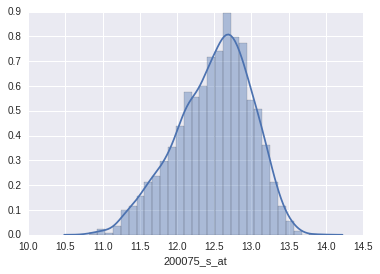

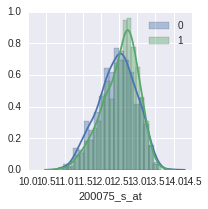

count    2337.000000
mean       12.493658
std         0.501716
min        10.822178
25%        12.158051
50%        12.554150
75%        12.862027
max        13.886034
Name: 200075_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200076_s_at
--------------------------------------------------------------------------------



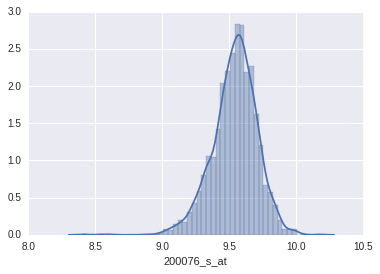

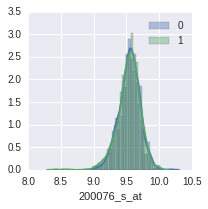

count    2337.000000
mean        9.541941
std         0.166445
min         8.405075
25%         9.447331
50%         9.555189
75%         9.652650
max        10.181981
Name: 200076_s_at, dtype: float64

--------------------------------------------------------------------------------
featuer:200077_s_at
--------------------------------------------------------------------------------



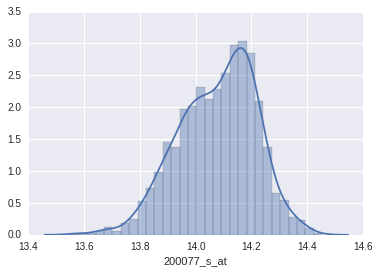

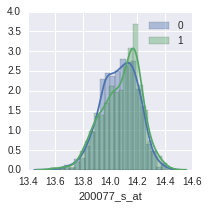

count    2337.000000
mean       14.077946
std         0.138791
min        13.551839
25%        13.981100
50%        14.093807
75%        14.181151
max        14.453358
Name: 200077_s_at, dtype: float64


In [17]:
visualize_distro(data,features=None,cols_index_range = range(100,110,1),target="SHEDDING_SC1")

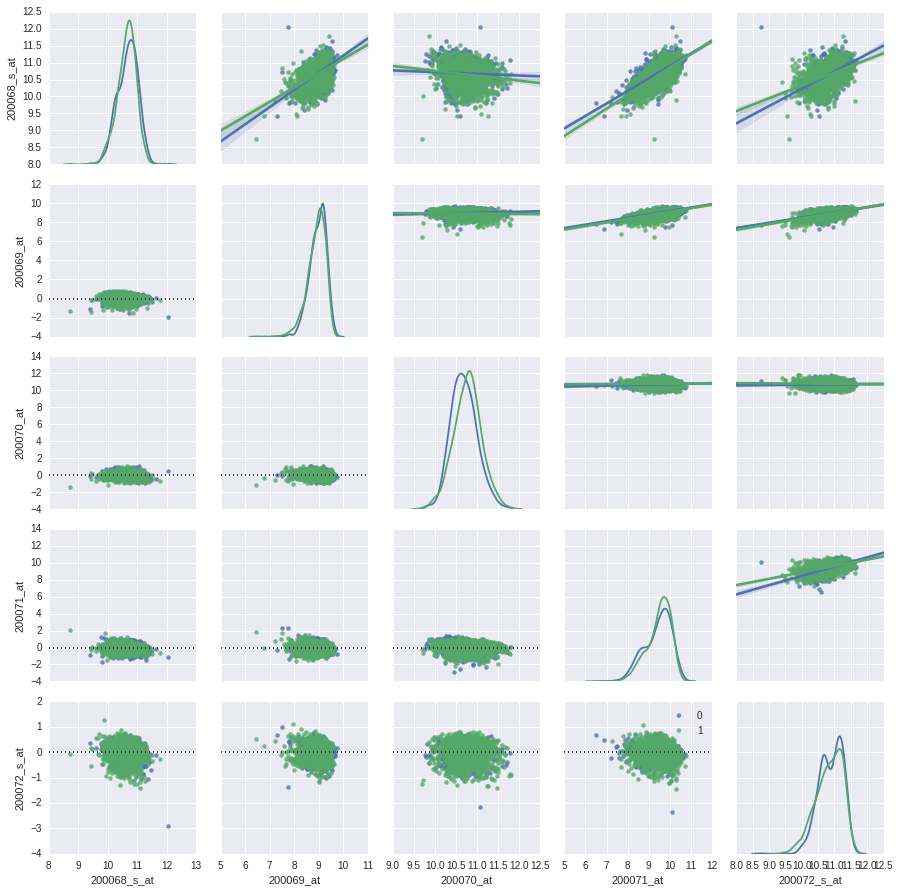

In [18]:
visualize_pair_wise(data,cols_index_range=range(100,105,1))


--------------------------------------------------------------------------------
feature:200068_s_at Vs. feature:200069_at
--------------------------------------------------------------------------------



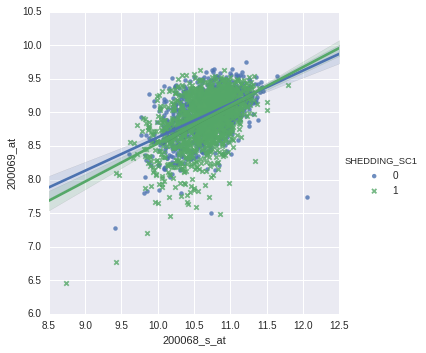

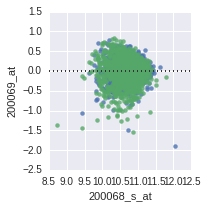

In [19]:
visualize_scatter(data,feature_idx1=100,feature_idx2=101)

# cross valdiation 

In [20]:
studies = data["STUDYID"].unique()
for study in studies: 
    seperator(study)
    data_before = data.loc[(data["STUDYID"] == study),:]
#     print(data_before["SUBJECTID"].value_counts())
    print(len(data_before["SUBJECTID"].unique()))
    


--------------------------------------------------------------------------------
DEE1 RSV
--------------------------------------------------------------------------------

20

--------------------------------------------------------------------------------
DEE2 H3N2
--------------------------------------------------------------------------------

17

--------------------------------------------------------------------------------
DEE3 H1N1
--------------------------------------------------------------------------------

24

--------------------------------------------------------------------------------
DEE4X H1N1
--------------------------------------------------------------------------------

12

--------------------------------------------------------------------------------
DEE5 H3N2
--------------------------------------------------------------------------------

26

--------------------------------------------------------------------------------
Rhinovirus Duke
-----------------

In [21]:
data.loc[list(data["SUBJECTID"] == "18"),:]

,STUDYID,SUBJECTID,AGE,GENDER,EARLYTX,SHAM,SHEDDING_SC1,SYMPTOMATIC_SC2,LOGSYMPTSCORE_SC3,TIMEHOURS,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
2097,Rhinovirus UVA,18,19,Female,0.0,0.0,0,0,0.30103,-24.0,...,13.164909,12.474681,14.270698,14.243535,4.255274,4.329172,3.691621,3.67132,3.933126,3.895557


In [22]:
data["SUBJECTID"] = [str(i) for i in data["SUBJECTID"].values]

In [23]:
#get all data of time <= 0 
data_before_infection = data.loc[(data["TIMEHOURS"]<=0) & (data["SHAM"] != 1),:]

#drop sham 
data_before_infection = data_before_infection.drop("SHAM",axis=1)
print(data_before_infection.info())
print(data_before_infection.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 2119
Columns: 22288 entries, STUDYID to AFFX-TrpnX-M_at
dtypes: float64(22280), int64(3), object(5)
memory usage: 36.1+ MB
None
    STUDYID SUBJECTID  AGE  GENDER  EARLYTX  SHEDDING_SC1  SYMPTOMATIC_SC2  \
0  DEE1 RSV    RSV004   25    Male      0.0             0                0   
1  DEE1 RSV    RSV020   31    Male      0.0             1                1   
2  DEE1 RSV    RSV010   30  Female      0.0             0                0   
3  DEE1 RSV    RSV009   23  Female      0.0             0                0   
4  DEE1 RSV    RSV018   22    Male      0.0             1                1   

   LOGSYMPTSCORE_SC3  TIMEHOURS       SAMPLEID       ...         \
0           0.000000      -24.0  DU08-02S09371       ...          
1           1.230449      -24.0  DU08-02S09500       ...          
2           0.477121      -24.0  DU08-02S09374       ...          
3           0.477121      -24.0  DU08-02S09357       ...          


In [24]:

    

data_before_infection.info()
#merge all data with subject id same together (avg )
groupby_subjectid = data_before_infection.groupby(["SUBJECTID","STUDYID","GENDER"],as_index=False).mean()


#clean data and save it

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 2119
Columns: 22288 entries, STUDYID to AFFX-TrpnX-M_at
dtypes: float64(22280), int64(3), object(5)
memory usage: 36.1+ MB


In [25]:
groupby_subjectid.info()
print(groupby_subjectid["STUDYID"].value_counts())

#rhino 20(13/16) -> 26 
a= groupby_subjectid.loc[groupby_subjectid["STUDYID"]=="Rhinovirus UVA"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Columns: 22286 entries, SUBJECTID to AFFX-TrpnX-M_at
dtypes: float64(22280), int64(3), object(3)
memory usage: 20.1+ MB
DEE3 H1N1          24
DEE1 RSV           20
Rhinovirus UVA     20
DEE2 H3N2          17
DEE5 H3N2          13
Rhinovirus Duke    12
DEE4X H1N1         12
Name: STUDYID, dtype: int64


In [26]:
groupby_subjectid.to_csv(path_or_buf="/home/sanders/data/viral/data_before_cleaned.csv")
#save the fucking d



In [27]:
groupby_subjectid.select_dtypes(include=["object"])


,SUBJECTID,STUDYID,GENDER
0,1,Rhinovirus UVA,Male
1,10,Rhinovirus UVA,Male
2,11,Rhinovirus UVA,Female
3,12,Rhinovirus UVA,Male
4,13,Rhinovirus UVA,Male
5,14,Rhinovirus UVA,Male
6,15,Rhinovirus UVA,Female
7,16,Rhinovirus UVA,Male
8,17,Rhinovirus UVA,Female
9,18,Rhinovirus UVA,Female


# begin ml 

In [3]:
path_train_x = "/home/sanders/data/viral/data_x_before_numeric.csv"
path_train_y = "/home/sanders/data/viral/data_y_before_numeric.csv"
path_valid_x = "/home/sanders/data/viral/valid_x_before_numeric.csv"
path_valid_y = "/home/sanders/data/viral/valid_y_before_numeric.csv"
data_x, data_y,valid_x,valid_y = pd.read_csv(path_train_x),pd.read_csv(path_train_y),pd.read_csv(path_valid_x),pd.read_csv(path_valid_y)
seperator("data_x")
print(data_x.info())
seperator("data_y")
print(data_y.info())
seperator("valid_x")
print(valid_x.info())
seperator("valid_y")
print(valid_y.info())


data = pd.concat([data_x,data_y],axis=1)
valid = pd.concat([valid_x,valid_y],axis=1)


--------------------------------------------------------------------------------
data_x
--------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Columns: 22289 entries, Unnamed: 0 to GENDER_Male
dtypes: float64(22287), int64(2)
memory usage: 16.2 MB
None

--------------------------------------------------------------------------------
data_y
--------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
Unnamed: 0           95 non-null int64
SHEDDING_SC1         95 non-null int64
SYMPTOMATIC_SC2      95 non-null int64
LOGSYMPTSCORE_SC3    95 non-null float64
dtypes: float64(1), int64(3)
memory usage: 3.0 KB
None

--------------------------------------------------------------------------------
valid_x
-------------------------------------------------------------------------

1    0.608696
0    0.391304
Name: SHEDDING_SC1, dtype: float64


1    0.631579
0    0.368421
Name: SHEDDING_SC1, dtype: float64

In [4]:
data_x = data_x.drop("Unnamed: 0",axis=1)
data_y = data_y.drop("Unnamed: 0",axis=1)
valid_x = valid_x.drop("Unnamed: 0",axis=1)
valid_y = valid_y.drop("Unnamed: 0",axis=1)

In [146]:
data_x.columns

Index(['AGE', 'EARLYTX', '1007_s_at', '1053_at', '117_at', '121_at',
       '1255_g_at', '1294_at', '1316_at', '1320_at',
       ...
       'AFFX-TrpnX-M_at', 'STUDYID_DEE1 RSV', 'STUDYID_DEE2 H3N2',
       'STUDYID_DEE3 H1N1', 'STUDYID_DEE4X H1N1', 'STUDYID_DEE5 H3N2',
       'STUDYID_Rhinovirus Duke', 'STUDYID_Rhinovirus UVA', 'GENDER_Female',
       'GENDER_Male'],
      dtype='object', length=22288)

In [205]:
#get numpy arrays 
train_x = data_x.values
train_y = data_y.values[:,0]
test_x = valid_x.values
test_y = valid_y.values[:,0]

In [6]:
print(train_y)
print(test_y)
print(len(train_y[train_y==1]))

[ 0.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.
  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.
  1.  0.  1.  0.  0.]
[ 1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.
  0.  1.  1.  0.  1.]
60


In [7]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(95, 22288)
(23, 22288)
(95,)
(23,)


Multiple eval metrics have been passed: 'logloss' will be used for early stopping.



[ 0.60979092  0.58630645  0.50217032  0.55482686  0.574655    0.56742692
  0.45460275  0.53603202  0.58778119  0.61656183  0.65984344  0.52422845
  0.63406318  0.57383215  0.59472102  0.57256442  0.62435323  0.58650082
  0.64105743  0.61444229  0.58194113  0.57433385  0.62954754]
0.515873015873 0.535602 999 1000
done

--------------------------------------------------------------------------------
auc
--------------------------------------------------------------------------------



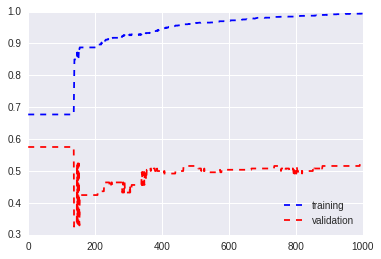


--------------------------------------------------------------------------------
error
--------------------------------------------------------------------------------



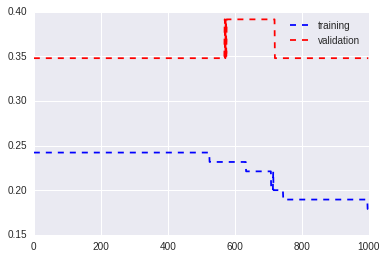


--------------------------------------------------------------------------------
logloss
--------------------------------------------------------------------------------



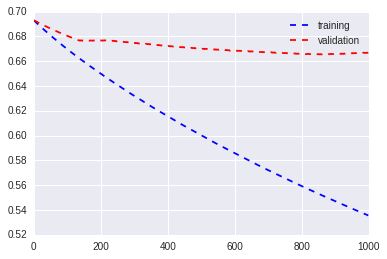

In [12]:
#fit xgboost 

# features_selected = [int(i) for i in features[:num_f]]


dtrain = xgb.DMatrix(train_x,label=train_y,feature_names=data_x.columns)
dtest = xgb.DMatrix(test_x,label=test_y,feature_names=data_x.columns)

#specify the validation set to watch performance 
evallist = [(dtest,"eval"),(dtrain,"train")]

#specify parameter via map and eval metric for cv 
eval_scores_dict = {}
param = {"max_depth":1,"eta":0.001,"subsample":1,"colsample_bytree":1,"min_child_weight":3,"gamma":0,"alpha":0,
         "lambda":1,"silent":0,"objective":"binary:logistic","eval_metric":["error","auc","logloss"]}
bst = xgb.train(param,dtrain,num_boost_round=1000,early_stopping_rounds=1000,
                evals=evallist,verbose_eval=False,evals_result=eval_scores_dict)
# bst = xgb.cv(params=param, dtrain=dtrain, num_boost_round=num_round, nfold=3,metrics=["error"],
#            show_progress=True)
#make prediction 
preds = bst.predict(dtest)
print(preds)
print(metrics.roc_auc_score(test_y,preds),bst.best_score,bst.best_iteration,bst.best_ntree_limit)
print("done")

plot_xgboost_training()

In [11]:
def plot_xgboost_training():
    seperator("auc")
    train_scores = np.asarray(eval_scores_dict["train"]["auc"])
    valid_scores = np.asarray(eval_scores_dict["eval"]["auc"])
    plot_validation_curve(train_scores,valid_scores,ticks=range(train_scores.shape[0]))

    seperator("error")
    train_scores = np.asarray(eval_scores_dict["train"]["error"])
    valid_scores = np.asarray(eval_scores_dict["eval"]["error"])
    plot_validation_curve(train_scores,valid_scores,ticks=range(train_scores.shape[0]))

    seperator("logloss")
    train_scores = np.asarray(eval_scores_dict["train"]["logloss"])
    valid_scores = np.asarray(eval_scores_dict["eval"]["logloss"])
    plot_validation_curve(train_scores,valid_scores,ticks=range(train_scores.shape[0]))

('200736_s_at', 203)
('207170_s_at', 132)
('201720_s_at', 105)
('215469_at', 98)
('218840_s_at', 76)
('205661_s_at', 70)
('206291_at', 69)
('214929_s_at', 68)
('217804_s_at', 50)
('215563_s_at', 42)
('203938_s_at', 38)
('206871_at', 19)
('217086_at', 17)
('219882_at', 13)


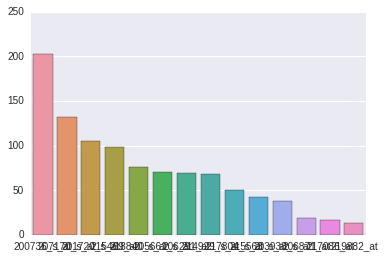

In [13]:
#feature importance 
top_k = 1000
features = []
f_scores = []
for k, v in sorted(bst.get_fscore().items(),key= lambda item:-item[1]):
    print((k,v))
    features.append(k)
    f_scores.append(v)

sns.barplot(features[:top_k],f_scores[:top_k],order=features[:top_k])


--------------------------------------------------------------------------------
Using only top 0 features:
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
using feature:200736_s_at
--------------------------------------------------------------------------------



Multiple eval metrics have been passed: 'logloss' will be used for early stopping.



[ 0.63951582  0.63951582  0.63951582  0.63951582  0.63951582  0.63951582
  0.27804297  0.27804297  0.63951582  0.63951582  0.63951582  0.27804297
  0.63951582  0.63951582  0.63951582  0.63951582  0.63951582  0.63951582
  0.63951582  0.63951582  0.63951582  0.63951582  0.63951582]
0.575396825397 0.573014 999 1000
done

--------------------------------------------------------------------------------
auc
--------------------------------------------------------------------------------



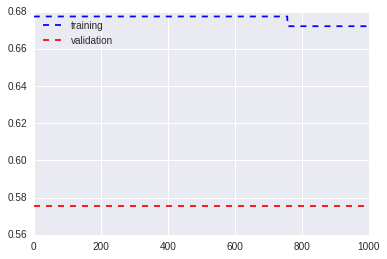


--------------------------------------------------------------------------------
error
--------------------------------------------------------------------------------



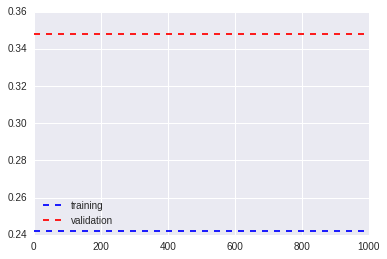


--------------------------------------------------------------------------------
logloss
--------------------------------------------------------------------------------



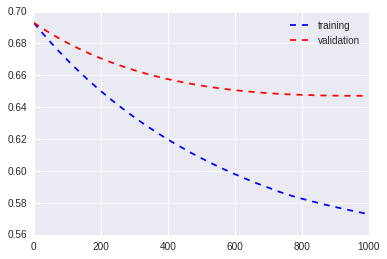


--------------------------------------------------------------------------------
Using only top 3 features:
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
using feature:215469_at
--------------------------------------------------------------------------------



Multiple eval metrics have been passed: 'logloss' will be used for early stopping.



[ 0.68547493  0.68547493  0.4374314   0.68547493  0.46570933  0.68547493
  0.68547493  0.68547493  0.68547493  0.4374314   0.68547493  0.68547493
  0.4374314   0.4374314   0.68547493  0.4374314   0.68547493  0.4374314
  0.46570933  0.68547493  0.68547493  0.4374314   0.68547493]
0.702380952381 0.591214 999 1000
done

--------------------------------------------------------------------------------
auc
--------------------------------------------------------------------------------



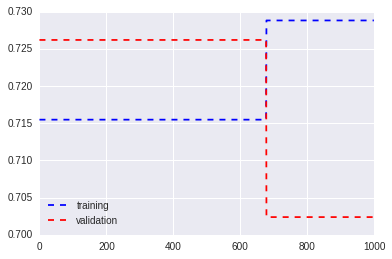


--------------------------------------------------------------------------------
error
--------------------------------------------------------------------------------



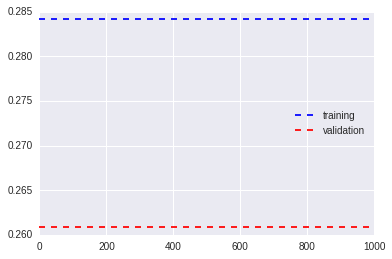


--------------------------------------------------------------------------------
logloss
--------------------------------------------------------------------------------



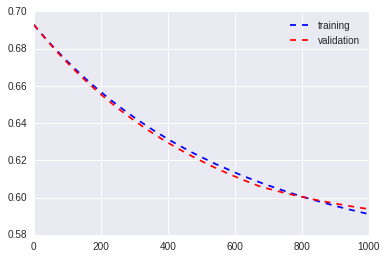

In [56]:

num_features = range(1,len(features),1)
scores_num_features = []

for num_f in [0,3]: 
    
    seperator("Using only top %i features:"%num_f)
    seperator("using feature:%s"%features[num_f])
    
    features_selected = features[num_f:num_f+1]
    
    dtrain = xgb.DMatrix(data_x.loc[:,features_selected].values,label=train_y,feature_names=features_selected)
    dtest = xgb.DMatrix(valid_x.loc[:,features_selected].values,label=test_y,feature_names=features_selected)

    #specify the validation set to watch performance 
    evallist = [(dtest,"eval"),(dtrain,"train")]

    #specify parameter via map and eval metric for cv 
    eval_scores_dict = {}
    param = {"max_depth":1,"eta":0.001,"subsample":1,"colsample_bytree":1,"min_child_weight":3,"gamma":0,"alpha":0,
             "lambda":1,"silent":0,"objective":"binary:logistic","eval_metric":["error","auc","logloss"]}
    bst = xgb.train(param,dtrain,num_boost_round=1000,early_stopping_rounds=1000,
                    evals=evallist,verbose_eval=False,evals_result=eval_scores_dict)
    # bst = xgb.cv(params=param, dtrain=dtrain, num_boost_round=num_round, nfold=3,metrics=["error"],
    #            show_progress=True)
    #make prediction 
    preds = bst.predict(dtest)
    print(preds)
    print(metrics.roc_auc_score(test_y,preds),bst.best_score,bst.best_iteration,bst.best_ntree_limit)
    print("done")
    
    
    plot_xgboost_training()
    scores_num_features.append(metrics.roc_auc_score(test_y,preds))

# plt.plot(num_features,scores_num_features,"ro")
# plt.plot(num_features,scores_num_features,"b--")
# plt.xlabel("number of features")
# plt.ylabel("auc score")


['200736_s_at', '207170_s_at', '201720_s_at', '215469_at']


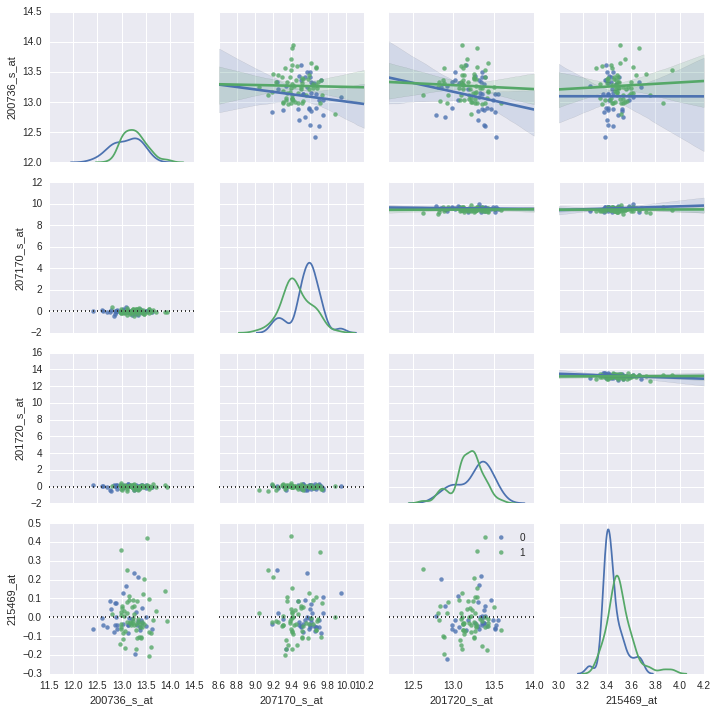

In [57]:
#lets visualize the top 4 features 

top_4_feature = features[:4]
print(top_4_feature)
visualize_pair_wise(data=data,feautures=top_4_feature,cols_index_range = None,target="SHEDDING_SC1")


--------------------------------------------------------------------------------
featuer:200736_s_at
--------------------------------------------------------------------------------



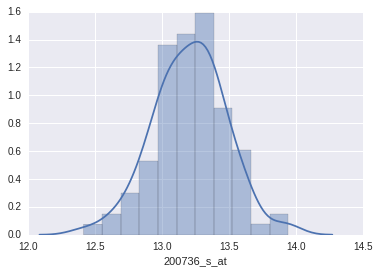

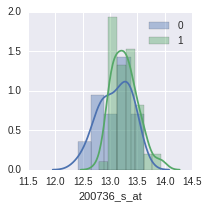

count    95.000000
mean     13.205973
std       0.273185
min      12.413237
25%      13.029191
50%      13.224158
75%      13.376378
max      13.942046
Name: 200736_s_at, dtype: float64


In [58]:
visualize_distro(data,features=features[0:1])

(95, 22288)

In [78]:
tiny = data.loc[:,features+["SHEDDING_SC1"]]
tiny_valid = valid.loc[:,features+["SHEDDING_SC1"]]
tiny.info()
tiny = tiny.values
tiny_valid = tiny_valid.values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 15 columns):
200736_s_at     95 non-null float64
207170_s_at     95 non-null float64
201720_s_at     95 non-null float64
215469_at       95 non-null float64
218840_s_at     95 non-null float64
205661_s_at     95 non-null float64
206291_at       95 non-null float64
214929_s_at     95 non-null float64
217804_s_at     95 non-null float64
215563_s_at     95 non-null float64
203938_s_at     95 non-null float64
206871_at       95 non-null float64
217086_at       95 non-null float64
219882_at       95 non-null float64
SHEDDING_SC1    95 non-null int64
dtypes: float64(14), int64(1)
memory usage: 11.2 KB


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] penalty=l1, C=0.01 ..............................................
[CV] penalty=l1, C=0.01 ..............................................
[CV] penalty=l1, C=0.01 ..............................................
[CV] penalty=l2, C=0.01 ..............................................
[CV] penalty=l2, C=0.01 ..............................................
[CV] penalty=l2, C=0.01 ..............................................
[CV] ..................... penalty=l1, C=0.01, score=0.500000 -   0.0s
[CV] ..................... penalty=l1, C=0.01, score=0.500000 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] penalty=l1, C=0.1 ...............................................
[CV] ..................... penalty=l2, C=0.01, score=0.387500 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] penalty=l2, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished
/home/sanders/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


# models to test on 
* logistic regression 
* random forests
* xgboost 
* naive bayes 
* knn 
* svm 
* nn 

# visualize 
* accuarcy (0/1)
* auc score (probs)
* training , validation curve if applicable 
* plot 0/1 class based on ? 
* confusion matrix 
* feature importances


In [6]:
def the_red_button(train_x,train_y,test_x,test_y,verbose = False): 
    model_to_test =range(6) #pick the models we want to evaluate on 
    feature_ranking = []
    best_auc_scores = []
    models = [ensemble.GradientBoostingClassifier(random_state=seed),ensemble.RandomForestClassifier(n_jobs=-1),
              tree.DecisionTreeClassifier(),naive_bayes.GaussianNB(),neighbors.KNeighborsClassifier(n_jobs=-1),
              svm.SVC(probability=True,cache_size=1000,random_state=seed),linear_model.LogisticRegression()]
    param_grids = [{"learning_rate":[0.01],"n_estimators":[500,1000],"subsample":[0.5,1],"max_depth":[3,6]},
        {"n_estimators":[5,10,100],"criterion":["gini","entropy"],"max_depth":[3,5,7]},
        {"criterion":["gini","entropy"],"max_depth":[1,3,6,10]},
        {},
                   {"n_neighbors":[3,5,9,13]},
        {"C":[0.001,0.01,0.1,1],"kernel":["linear","poly","rbf"]},
            {"penalty":["l1","l2"],"C":[0.001,0.01,0.1,1,10]}]
    for idx in model_to_test:
        model = models[idx]
        param_grid = param_grids[idx]
        clf = grid_search.GridSearchCV(model,param_grid=param_grid,scoring="roc_auc",n_jobs=-1,verbose=0)
        clf.fit(train_x,train_y)
        
        
        best_auc_scores.append(metrics.roc_auc_score(test_y,clf.predict_proba(test_x)[:,1]))

#         if hasattr(model,"feature_importances_"):
#             feature_ranking.append(model.feature_importances_)
        if verbose: 
            seperator(str(model))
            
            print("\naccuaracy on train:%3.8f\naccuarcy on test:%3.8f\nauc score on test:%3.8f"%(metrics.accuracy_score(train_y,clf.predict(train_x)),
                                                                                        metrics.accuracy_score(test_y,clf.predict(test_x)),
                                                                                         metrics.roc_auc_score(test_y,clf.predict_proba(test_x)[:,1])))

    

            print("best auc score:%3.8f\nbest params:%s\nbest estimator:%s "%(clf.best_score_,clf.best_params_,clf.best_estimator_))
            visualize_training(clf.grid_scores_)
                               
    seperator("final summary")
    sumarry(best_auc_scores)
    return sum(best_auc_scores)/float(len(best_auc_scores))

def visualize_training(grid_scores):
    for fit in grid_scores:
        print(fit)
def sumarry(best_auc_scores):
    print(sum(best_auc_scores)/float(len(best_auc_scores)))
    print()
    for score in best_auc_scores:
        print(score)
    
    


In [209]:
#pipline 
scaler = preprocessing.StandardScaler().fit(train_x)
train_x =  scaler.transform(train_x)
test_x = scaler.transform(test_x)



In [175]:
#test on vairaous algos 
the_red_button(train_x[:,[265,2297]],train_y,test_x[:,[225,2297]],test_y,verbose=True)


--------------------------------------------------------------------------------
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
--------------------------------------------------------------------------------


accuaracy on train:1.00000000
accuarcy on test:0.56521739
auc score on test:0.53174603
best auc score:0.71406699
best params:{'subsample': 1, 'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 1000}
best estimator:GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=

In [159]:
a = ['200736_s_at', '207170_s_at']
list(data_x.columns).index('207170_s_at')

6697

In [7]:
iris = datasets.load_iris()
x = iris.data
y = iris.target
y = [1 if i>1 else 0 for i in y]
tr_x,te_x,tr_y,te_y = cross_validation.train_test_split(x,y,test_size = 0.4)
the_red_button(tr_x,tr_y,te_x,te_y,verbose=True)


--------------------------------------------------------------------------------
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
--------------------------------------------------------------------------------


accuaracy on train:1.00000000
accuarcy on test:0.95000000
auc score on test:0.99023199
best auc score:0.99820988
best params:{'n_estimators': 500, 'subsample': 0.5, 'max_depth': 3, 'learning_rate': 0.01}
best estimator:GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators

0.97588522588522586

In [201]:
feature_scores = []
for i in range(100): 
    seperator(str(i))
    feature_scores.append(the_red_button(train_x[:,i:(i+2)],train_y,test_x[:,i:(i+2)],test_y))
seperator()   
for idx,score in enumerate(feature_scores): 
    print("feature %i:%3.8f"%(idx,score))
    
    


--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
final summary
--------------------------------------------------------------------------------

0.5

0.5

--------------------------------------------------------------------------------
1
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
final summary
--------------------------------------------------------------------------------

0.5

0.5

--------------------------------------------------------------------------------
2
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
final summary
--------------------------------